# Week 11 - Introduction to Modeling, part 2

# 1. Lesson - No lesson this week

___

# 2. Weekly graph question

In [65]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from tqdm import tqdm
from itertools import chain, combinations

The book names one of Vonnegut's rules as "keep it simple" and another as "have the guts to cut."  Here is some data from the previous week's lesson.  If you had to cut one of the two plots below, which would it be?  Which seems more interesting or important?  Explain.  (Should "amount of training data used" or "number of estimators" be on the x-axis.)

**Answer**

I would cut the graph detailing n_estimators and keep the one showing the loss function alongside the amount of training data used. My reasoning is that the amount of training data is more important and provides more meaningful insight for stakeholders. In contrast, n_estimators is just one of many hyperparameters in the RandomForestRegressor model.

There’s no clear reason why this particular hyperparameter should be highlighted over others like max_features, max_depth, or bootstrap, all of which can significantly affect model performance. Without also showing those, focusing solely on n_estimators feels arbitrary. Moreover, hyperparameter choices can be systematically justified through techniques like a parameter sweep or GridSearchCV, and then simply reported as the best-performing configuration.

The amount of training data, on the other hand, provides novel and potentially non-intuitive insight. If, for example, the optimal performance wasn’t achieved by using all available data, showing this could help justify your design choices to stakeholders or consumers of the report.

In [4]:
np.random.seed(0)
num_points = 10000
feature_1a = np.random.random(size = num_points) * 3
feature_2a = np.random.random(size = num_points) * 3
feature_3a = np.random.random(size = num_points) * 3
train_target = (feature_1a - 2 * feature_2a) * feature_3a + np.random.normal(size = num_points)
feature_1b = np.random.random(size = num_points) * 3
feature_2b = np.random.random(size = num_points) * 3
feature_3b = np.random.random(size = num_points) * 3
test_target = (feature_1b - 2 * feature_2b) * feature_3b + np.random.normal(size = num_points)
train_df = pd.DataFrame({"f1": feature_1a, "f2": feature_2a, "f3": feature_3a})
test_df = pd.DataFrame({"f1": feature_1b, "f2": feature_2b, "f3": feature_3b})
rf = RandomForestRegressor()
rf.fit(train_df.values, train_target)

RandomForestRegressor()

In [5]:
rmse_lst = list()
rf = RandomForestRegressor()
for x in range(round(num_points / 20), num_points, round(num_points / 20)):
    rf.fit(train_df.values[0:x,:], train_target[0:x])
    rmse_lst.append(root_mean_squared_error(rf.predict(test_df.values), test_target))

import matplotlib.pyplot as plt

Text(0, 0.5, 'Loss function')

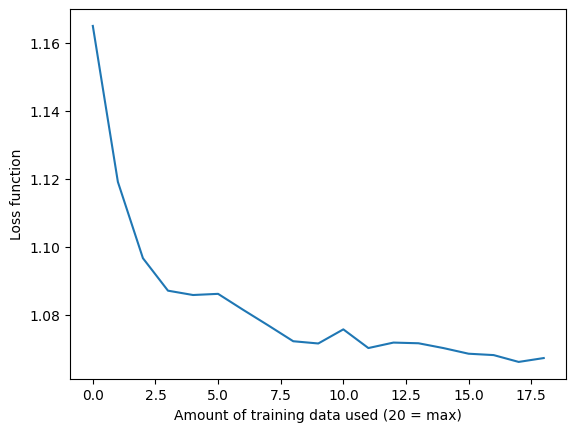

In [6]:
plt.plot(rmse_lst)
plt.xlabel("Amount of training data used (20 = max)")
plt.ylabel("Loss function")

In [7]:
num_trees_lst = list()
for n_estimators in range(1, 100, 3):
    rf = RandomForestRegressor(n_estimators = n_estimators)
    rf.fit(train_df.values, train_target)
    num_trees_lst.append(root_mean_squared_error(rf.predict(test_df.values), test_target))

Text(0, 0.5, 'Loss function')

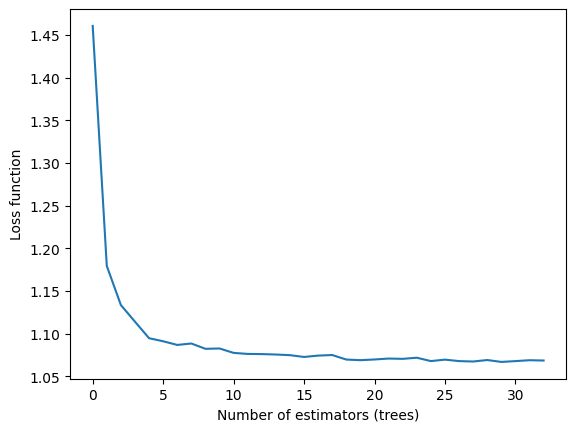

In [8]:
plt.plot(num_trees_lst)
plt.xlabel("Number of estimators (trees)")
plt.ylabel("Loss function")

___

# 3. Working on your datasets

#### **For brevity here, analysis will consist of work done to the NFL First and Future Dataset. Full multivariate analysis including PCA, logistic regression and random forests on the Punt Analytics and Big Data Bowl datasets will be done seperately and turned in with the Final Milestone**

This week, you will do the same types of exercises as last week, but you should use your own datasets that you found last semester.

Here are some types of analysis you can do:

* Implement a random forest model.
* Perform cross-validation.
* Tune hyperparameters.
* Evaluate a performance metric.

If you like, you can try other types of models, too (beyond linear regression and random forest) although you will have many opportunities to do that next semester.

#### **Part 3 Prelude: Import datasets, profile to double check, and prepare for Modeling**


In [13]:
# ========================================================================================
# This is meant to consolidate the 'show_null_counts_features' function from before with 
# another with 'value' and 'unique' counts later on in this analysis. 
# ========================================================================================

def profile_dataset(df):
    # Identify feature types
    feature_types = df.dtypes.apply(lambda x: 'Numeric' if np.issubdtype(x, np.number) else 'Categorical')

    # Build a summary DataFrame
    summary = pd.DataFrame({
        'Feature': df.columns,
        'Type': feature_types.values,
        'Null Values': df.isnull().sum().values,
        'Null %': (df.isnull().mean() * 100).round(2).values,
        'Count (Non-Null)': df.count().values,
        'Unique Values': df.nunique().values
    })

    # Sort Values in Summary by % of null values
    summary = summary.sort_values(by='Null %', ascending=False).reset_index(drop=True)

    # Add dataset shape info above the table
    print(f"This dataset contain {df.shape[0]} rows")
    print(f"This dataset contain {df.shape[1]} columns")

    # Display the summary
    return summary

Now let's prepare a run_model wrapper function to handle the classification -- this is taken and modified from the Mod 3 final milestone. 

In [28]:
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score

def run_classifier_model(
    model,
    X_train,
    y_train,
    X_test=None,
    y_test=None,
    scoring='f1',
    n_repeats=5,
    n_jobs=-1,
    concat_results=False,
    run_comment=None,
    plot_pred=False,
    **model_params
):
    global combined_results

    model_instance = model(**model_params) if isinstance(model, type) else model
    model_name = model.__name__ if isinstance(model, type) else model.__class__.__name__

    # --- Cross-validation ---
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=n_repeats, random_state=42)
    cv_scores = cross_val_score(
        model_instance,
        X_train,
        y_train,
        scoring=scoring,
        cv=cv,
        n_jobs=n_jobs
    )

    mean_CV_score = np.mean(cv_scores)
    std_CV_score = np.std(cv_scores)

    # --- Train on full training set ---
    model_instance.fit(X_train, y_train)
    y_train_pred = model_instance.predict(X_train)

    # --- Evaluate on test set ---
    test_score = None
    y_test_pred = None
    if X_test is not None and y_test is not None:
        y_test_pred = model_instance.predict(X_test)
        test_score = f1_score(y_test, y_test_pred, zero_division=0)

    if plot_pred and y_test_pred is not None:
        print("Confusion Matrix:")
        print(confusion_matrix(y_test, y_test_pred))
        print("\nClassification Report:")
        print(classification_report(y_test, y_test_pred, digits=3))

    # --- Collect results ---
    results_df = pd.DataFrame([{
        "model": model_name,
        "model_params": model_instance.get_params(),
        f"mean_CV_{scoring}": mean_CV_score,
        f"std_CV_{scoring}": std_CV_score,
        f"test_{scoring}": test_score,
        "run_comment": run_comment
    }])

    if concat_results:
        try:
            combined_results = pd.concat([combined_results, results_df], ignore_index=True)
        except NameError:
            combined_results = results_df

    return results_df

And import a parameter Sweep function -- again taken from Mod 3 and edited for use in classification

In [59]:
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold

def run_classifier_model_for_sweep(
    model,
    X_train,
    y_train,
    X_test=None,
    y_test=None,
    scoring='balanced_accuracy',
    n_repeats=5,
    n_jobs=-1,
    **model_params
):
    # Instantiate model if passed as a class
    if isinstance(model, type):
        model = model(**model_params)

    # Cross-validation
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=n_repeats, random_state=42)
    cv_scores = cross_val_score(
        model, X_train, y_train,
        scoring=scoring,
        cv=cv,
        n_jobs=n_jobs
    )

    mean_cv_score = np.mean(cv_scores)
    std_cv_score = np.std(cv_scores)

    # Fit on full train set
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    train_score = f1_score(y_train, y_train_pred, zero_division=0)

    test_score = None
    if X_test is not None and y_test is not None:
        y_test_pred = model.predict(X_test)
        test_score = f1_score(y_test, y_test_pred, zero_division=0)

    return mean_cv_score, std_cv_score, train_score, test_score

In [61]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import numpy as np
import pandas as pd

def sweep_parameter_classifier(model,
                    Parameters,
                    param,
                    parameter_list,
                    X_train,
                    y_train,
                    X_test=None,
                    y_test=None,
                    scoring='balanced_accuracy',
                    verbose=True,
                    n_iter_no_change=None,
                    delta=0.001,
                    n_jobs=-1,
                    n_repeats=5):
    
    start = time.time()
    Parameters = Parameters.copy()
    
    cv_scores, std_cvs, train_scores, test_scores = [], [], [], []
    no_improve_count = 0
    best_score = 0  # Higher is better (for F1, balanced accuracy, etc.)

    for p in tqdm(parameter_list, desc=f"Sweeping {param} ({scoring})"):
        Parameters[param] = p
        P_temp = Parameters.copy()
        P_temp.pop('Score_found', None)

        mean_cv, std_cv, train_score, test_score = run_classifier_model_for_sweep(
            model=model,
            X_train=X_train, y_train=y_train,
            X_test=X_test,   y_test=y_test,
            scoring=scoring,
            n_repeats=n_repeats,
            n_jobs=n_jobs,
            **P_temp
        )
        
        cv_scores.append(mean_cv)
        std_cvs.append(std_cv)
        train_scores.append(train_score)
        test_scores.append(test_score)

        # Early stopping
        if mean_cv > best_score + delta:
            best_score = mean_cv
            no_improve_count = 0
        else:
            no_improve_count += 1

        if n_iter_no_change is not None and no_improve_count >= n_iter_no_change:
            print(f"Early stopping after {n_iter_no_change} rounds.")
            break

    # Save best parameter
    max_cv_score = max(cv_scores)
    max_index = cv_scores.index(max_cv_score)
    best_param = parameter_list[max_index]
    Parameters[param] = best_param
    Parameters['Score_found'] = max_cv_score

    if verbose:
        # Plotting
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), sharex=True)
        partial_param_list = parameter_list[:len(cv_scores)]
        
        is_boolean = all(isinstance(val, bool) for val in partial_param_list)
        x_vals = list(range(len(partial_param_list))) if is_boolean else partial_param_list
        x_labels = [str(val) for val in partial_param_list] if is_boolean else partial_param_list

        # Score plot
        ax1.set_title(f"{scoring.upper()} Score vs {param}")
        ax1.plot(x_vals, cv_scores, marker='o', label="CV Score", color='blue')
        ax1.plot(x_vals, train_scores, marker='o', label="Train Score", color='green')
        ax1.plot(x_vals, test_scores, linestyle='--', marker='o', label="Test Score", color='orange')
        ax1.scatter([x_vals[max_index]], [max_cv_score], marker='x', color='red', label="Best CV Score")
        ax1.set_ylabel(f"{scoring.upper()}")
        ax1.legend()
        ax1.grid()

        # Std deviation
        ax2.set_title(f"CV Std Dev vs {param}")
        ax2.plot(x_vals, std_cvs, marker='.', color='blue')
        ax2.set_xlabel(param)
        ax2.set_ylabel("Standard Deviation")
        ax2.grid()

        if is_boolean:
            ax2.set_xticks(x_vals)
            ax2.set_xticklabels(x_labels)

        plt.tight_layout()
        plt.show()

        end = time.time()
        print("Execution Time:", time.strftime("%H:%M:%S", time.gmtime(end - start)))
    
    return Parameters

Next, we'll import the df_encoded from Week 9 Homework -- This is *after* one hot variable encoding but before any standardization or train test splitting

In [ ]:
df_encoded = pd.read_csv('/Users/leemcfarling/Desktop/df_encoded.csv')

And here, we will drop the injury related columns along with the Inj Occured variable for the training set -- because these columns are only filled out when an injury occured, they can serve as a confounding factor on the model if not dropped here. 

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np

# Drop injury-related columns (and optionally PlayerDay)
injury_related_columns = [
    'Inj_Occured',
    'BodyPart_Ankle',
    'BodyPart_Foot',
    'BodyPart_Knee',
    'InjuryLength_0',
    'InjuryLength_1',
    'InjuryLength_7',
    'InjuryLength_28',
    'InjuryLength_42',
    'PlayerDay',
    'Unnamed: 0'  
]

# Split into Features / Target
X = df_encoded.drop(columns=injury_related_columns)
y = df_encoded['Inj_Occured']


# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [25]:
# Split into numeric and one hot 
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns
onehot_cols = X.select_dtypes(include=['uint8', 'bool']).columns

# Scale the numeric but not one hot
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[numeric_cols])
X_test_scaled = scaler.transform(X_test[numeric_cols])

# Combine numeric + one-hot
X_train_ready = np.hstack([X_train_scaled, X_train[onehot_cols].values])
X_test_ready = np.hstack([X_test_scaled, X_test[onehot_cols].values])

#### **Import Random Forest Classifier and Initiate Global Variables**

(I like to spell out the default parameters to get a feel for what knobs and dials we can turn later)

In [73]:
from sklearn.ensemble import RandomForestClassifier

baseline_classifier = RandomForestClassifier(
    n_estimators=100,       
    max_features='sqrt',    
    max_depth=None,         
    bootstrap=True,         

    min_samples_split=2,    
    min_samples_leaf=1,     
    oob_score=False,        
    criterion='gini',       
    random_state=42         
)

# =============================
# Global Variables
# =============================
random_state = 42
combined_results = pd.DataFrame()

#### **Random Forest Classifier w/ Default Parameters**

In [74]:
run_classifier_model(
          model=baseline_classifier,
          X_train=X_train_ready,
          y_train=y_train, 
          X_test=None, 
          y_test=None,
          scoring='f1',
          
          n_repeats=5,
          n_jobs=-1, 
          concat_results=True,
          run_comment="Baseline F1 Scoring", 
          plot_pred=False
          )


,model,model_params,mean_CV_f1,std_CV_f1,test_f1,run_comment
0,RandomForestClassifier,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",0.036484,0.064954,None,Baseline F1 Scoring


In [76]:
run_classifier_model(
          model=baseline_classifier,
          X_train=X_train_ready,
          y_train=y_train, 
          scoring='balanced_accuracy',

          n_repeats=5,
          n_jobs=-1, 
          concat_results=True,
          run_comment="Baseline 'balanced Accuracy' Scoring", 
          plot_pred=False
          )

,model,model_params,mean_CV_balanced_accuracy,std_CV_balanced_accuracy,test_balanced_accuracy,run_comment
0,RandomForestClassifier,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",0.509872,0.017577,None,Baseline 'balanced Accuracy' Scoring


**Quick analysis**

Out of the box, it looks like the model is doing a terrible job of predicting injury classes (which is likely due to the extreme class imbalance between injury / non-injury) -- If we drill further, and use 'balanced accuracy' as a scoring metric, than it would seem that the mean CV balanced accuracy .509 is barely better than the model randomly guessing (0.5) -- let's see if we can't get better results from hyperparameter tuning

In [36]:
combined_results

,model,model_params,mean_CV_f1,std_CV_f1,test_f1,run_comment,mean_CV_balanced_accuracy,std_CV_balanced_accuracy,test_balanced_accuracy
0,RandomForestClassifier,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",0.036484,0.064954,None,Baseline F1 Scoring,NaN,NaN,NaN
1,RandomForestClassifier,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",NaN,NaN,NaN,Baseline 'balanced Accuracy' Scoring,0.509872,0.017577,None


#### **Hyperparameter Tuning of RandomForestClassifier**

Right away, we can try to use a balancer in the Random Forest to see if that effects performance (I'll be using the balanced accuracy moving forward)

The first step that we will try is to manually add a balancer to the RandomForest

In [41]:
class_weight_classifier = RandomForestClassifier(
    n_estimators=100,       
    max_features='sqrt',    
    max_depth=None,         
    bootstrap=True,         

    min_samples_split=2,    
    min_samples_leaf=1,     
    oob_score=False,        
    criterion='gini',       
    class_weight='balanced',
    random_state=42         
)

In [42]:
run_classifier_model(
          model=class_weight_classifier,
          X_train=X_train_ready,
          y_train=y_train, 
          scoring='balanced_accuracy',

          n_repeats=5,
          n_jobs=-1, 
          concat_results=True,
          run_comment="Balancer Applied 'balanced Accuracy' Scoring", 
          plot_pred=False
          )

,model,model_params,mean_CV_balanced_accuracy,std_CV_balanced_accuracy,test_balanced_accuracy,run_comment
0,RandomForestClassifier,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",0.509872,0.017577,None,Balancer Applied 'balanced Accuracy' Scoring


And no improvement. Let's try a parameter sweep

#### **Parameter Sweep**

In [62]:
# Initial parameters
Default_Parameters_RandomForestClassifier = {
    'n_estimators': 100,
    'max_features': 'sqrt',
    'max_depth': None,
    'bootstrap': True,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'oob_score': False,
    'criterion': 'gini',
    'class_weight': 'balanced',
    'random_state': 42,
    'Score_found': 0
}

In [46]:
# Copy / Prep the RF Parameters for Sweeping
Parameters_RF = Default_Parameters_RandomForestClassifier.copy()
Parameters_RF_List = []

# And bring down our Variables from Before to avoid typos

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
# X_train_ready = np.hstack([X_train_scaled, X_train[onehot_cols].values])
# X_test_ready = np.hstack([X_test_scaled, X_test[onehot_cols].values])


Sweeping n_estimators (balanced_accuracy): 100%|██████████| 4/4 [04:15<00:00, 63.94s/it]


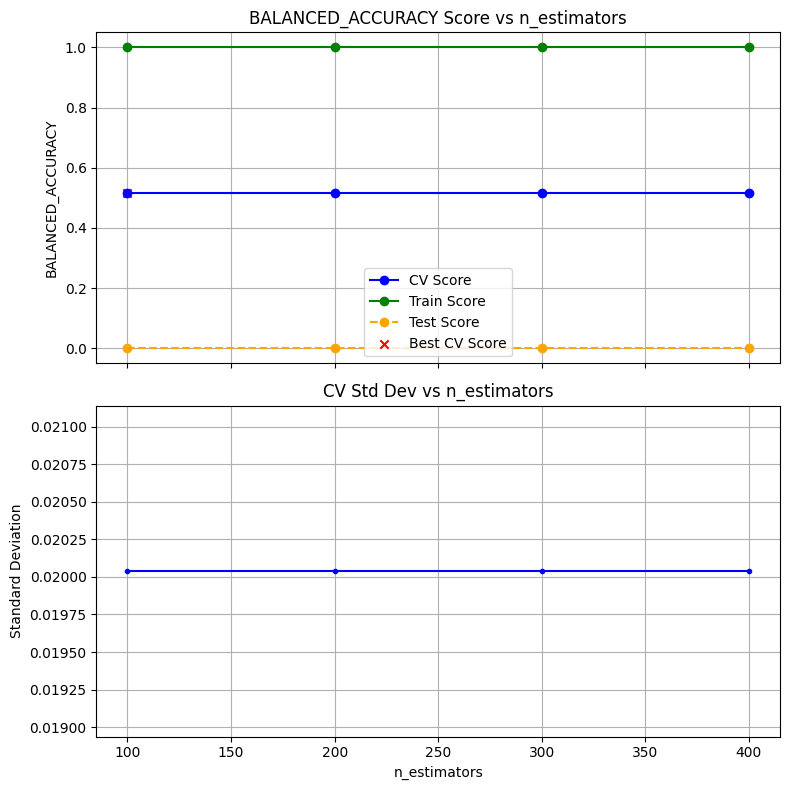

Execution Time: 00:04:15

Parameter n_estimators = 100    Best CV Score = 0.5163

{'n_estimators': 100, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': True, 'min_samples_split': 2, 'min_samples_leaf': 1, 'oob_score': False, 'criterion': 'gini', 'class_weight': 'balanced', 'random_state': 42, 'Score_found': np.float64(0.5163461538461538)}



Sweeping max_depth (balanced_accuracy): 100%|██████████| 4/4 [01:22<00:00, 20.68s/it]


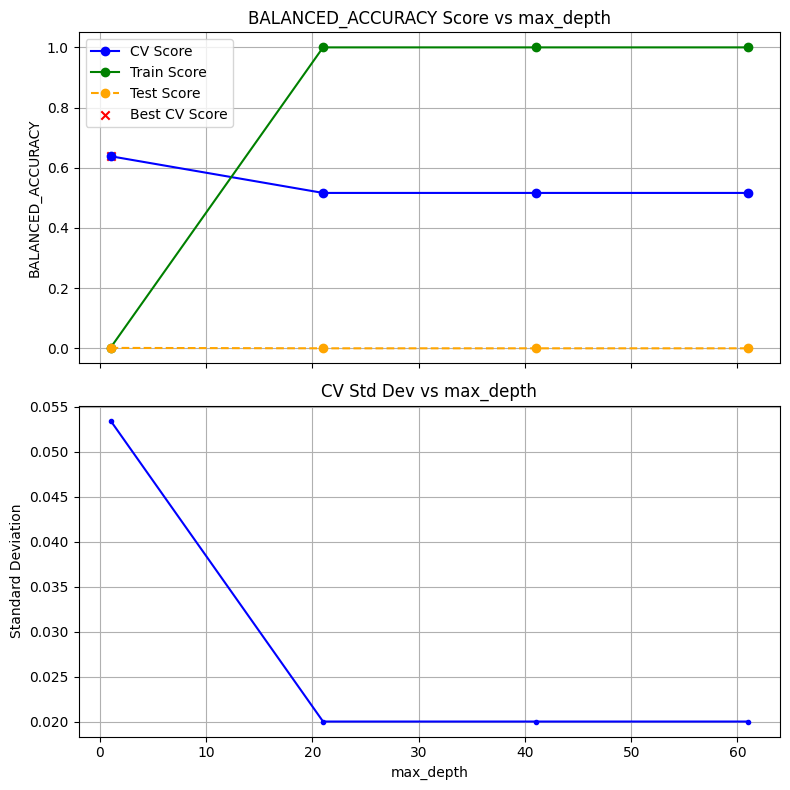

Execution Time: 00:01:22

Parameter max_depth = 1    Best CV Score = 0.6383

{'n_estimators': 100, 'max_features': 'sqrt', 'max_depth': 1, 'bootstrap': True, 'min_samples_split': 2, 'min_samples_leaf': 1, 'oob_score': False, 'criterion': 'gini', 'class_weight': 'balanced', 'random_state': 42, 'Score_found': np.float64(0.6383262803924933)}



Sweeping max_features (balanced_accuracy): 100%|██████████| 12/12 [03:12<00:00, 16.03s/it]


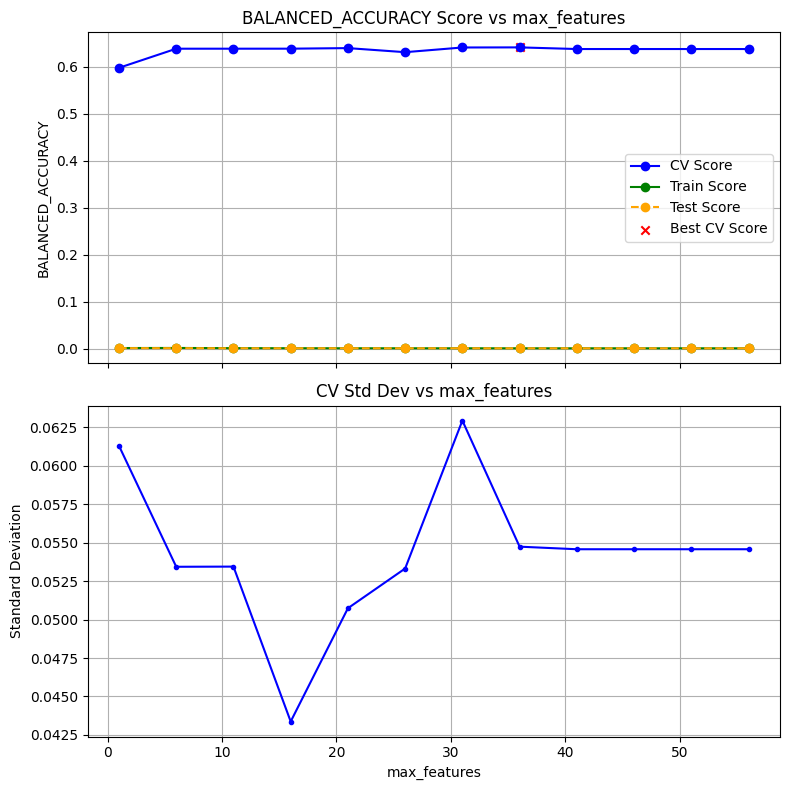

Execution Time: 00:03:12

Parameter max_features = 36    Best CV Score = 0.6411

{'n_estimators': 100, 'max_features': 36, 'max_depth': 1, 'bootstrap': True, 'min_samples_split': 2, 'min_samples_leaf': 1, 'oob_score': False, 'criterion': 'gini', 'class_weight': 'balanced', 'random_state': 42, 'Score_found': np.float64(0.6411447257237651)}



Sweeping bootstrap (balanced_accuracy): 100%|██████████| 2/2 [00:54<00:00, 27.41s/it]


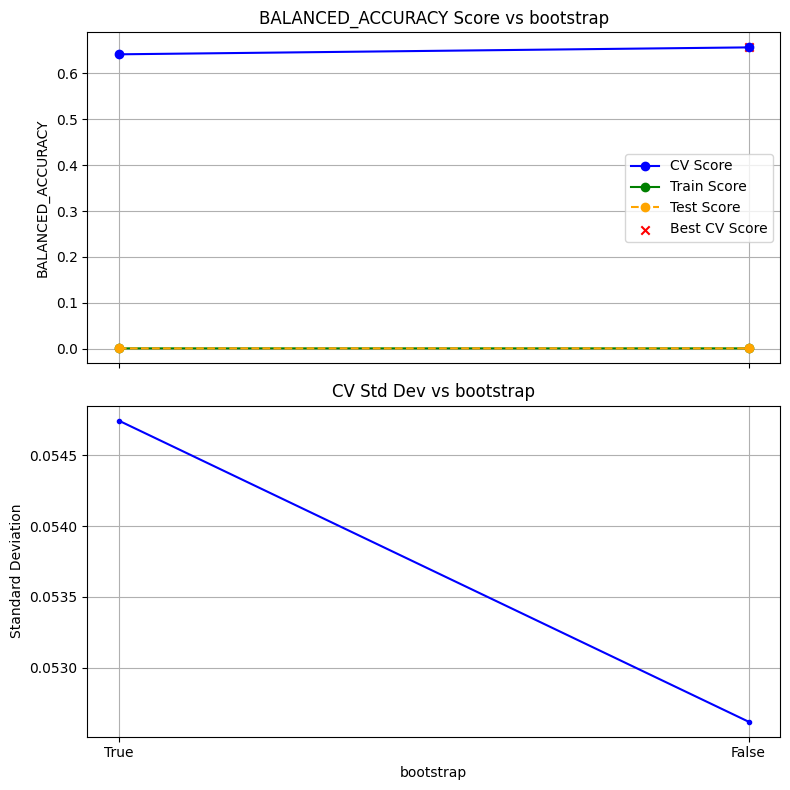

Execution Time: 00:00:54

Parameter bootstrap = False    Best CV Score = 0.6562

{'n_estimators': 100, 'max_features': 36, 'max_depth': 1, 'bootstrap': False, 'min_samples_split': 2, 'min_samples_leaf': 1, 'oob_score': False, 'criterion': 'gini', 'class_weight': 'balanced', 'random_state': 42, 'Score_found': np.float64(0.6562304219977774)}

   n_estimators max_features  max_depth  bootstrap  min_samples_split  \
0           100         sqrt        NaN       True                  2   
1           100         sqrt        1.0       True                  2   
2           100           36        1.0       True                  2   
3           100           36        1.0      False                  2   

   min_samples_leaf  oob_score criterion class_weight  random_state  \
0                 1      False      gini     balanced            42   
1                 1      False      gini     balanced            42   
2                 1      False      gini     balanced            42   
3      

In [63]:
from sklearn.ensemble import RandomForestClassifier

# Parameter grid
parameters_and_ranges = [
    ('n_estimators', range(100, 500, 100)),
    ('max_depth', range(1, 80, 20)),
    ('max_features', range(1, 60, 5)),
    ('bootstrap', [True, False])
]

for param, param_values in parameters_and_ranges:
    Parameters_RF = sweep_parameter_classifier(
        model=RandomForestClassifier,
        Parameters=Parameters_RF,
        param=param,
        parameter_list=param_values,
        X_train=X_train_ready,
        y_train=y_train,
        X_test=X_test_ready,
        y_test=y_test,
        scoring='balanced_accuracy',
        n_jobs=-1,
        n_repeats=2
    )

    print(f"\nParameter {param} = {Parameters_RF[param]}    Best CV Score = {Parameters_RF['Score_found']:.4f}\n")
    print(Parameters_RF)
    print()

    Parameters_RF_List.append(Parameters_RF.copy())

RF_Results = pd.DataFrame(Parameters_RF_List)
print(RF_Results)

#### **Parameter Sweep with Improved Ranges**


Sweeping n_estimators (balanced_accuracy): 100%|██████████| 10/10 [02:35<00:00, 15.54s/it]


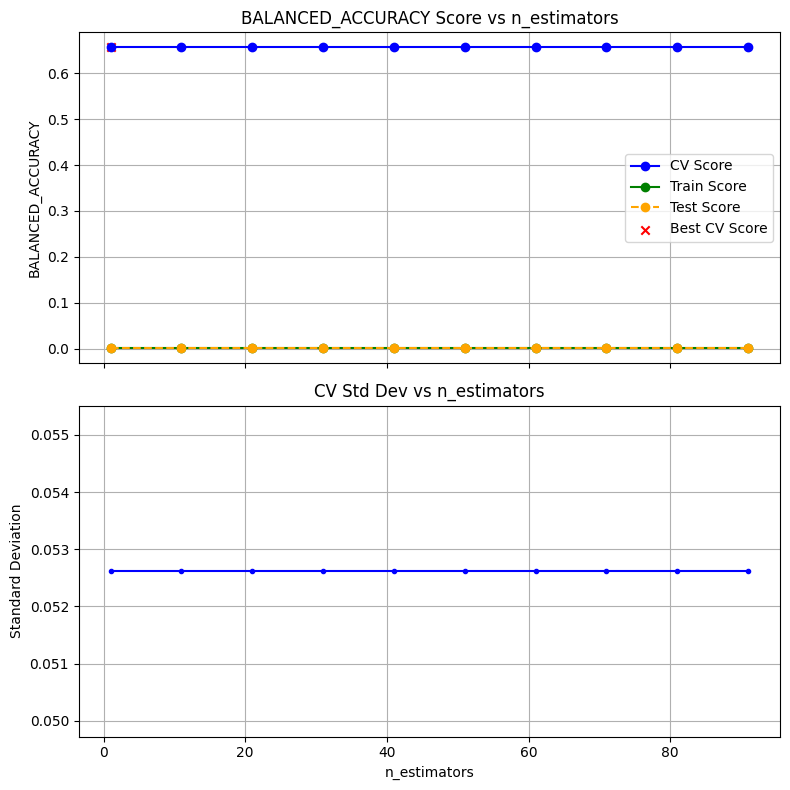

Execution Time: 00:02:35

Parameter n_estimators = 1    Best CV Score = 0.6562

{'n_estimators': 1, 'max_features': 36, 'max_depth': 1, 'bootstrap': False, 'min_samples_split': 2, 'min_samples_leaf': 1, 'oob_score': False, 'criterion': 'gini', 'class_weight': 'balanced', 'random_state': 42, 'Score_found': np.float64(0.6562304219977774)}



Sweeping max_depth (balanced_accuracy): 100%|██████████| 9/9 [00:14<00:00,  1.57s/it]


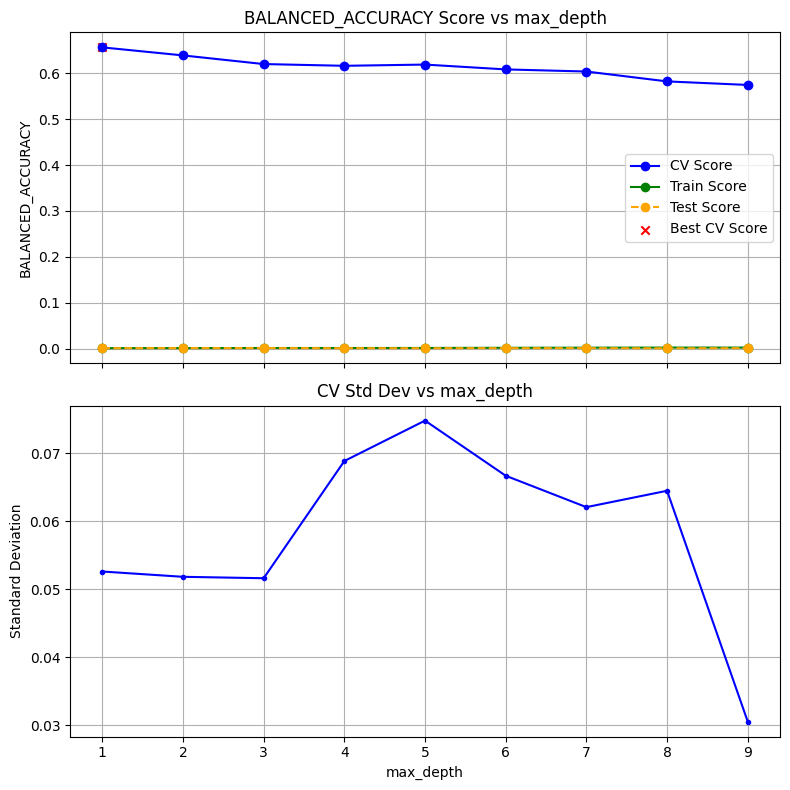

Execution Time: 00:00:14

Parameter max_depth = 1    Best CV Score = 0.6562

{'n_estimators': 1, 'max_features': 36, 'max_depth': 1, 'bootstrap': False, 'min_samples_split': 2, 'min_samples_leaf': 1, 'oob_score': False, 'criterion': 'gini', 'class_weight': 'balanced', 'random_state': 42, 'Score_found': np.float64(0.6562304219977774)}



Sweeping max_features (balanced_accuracy): 100%|██████████| 11/11 [00:06<00:00,  1.68it/s]


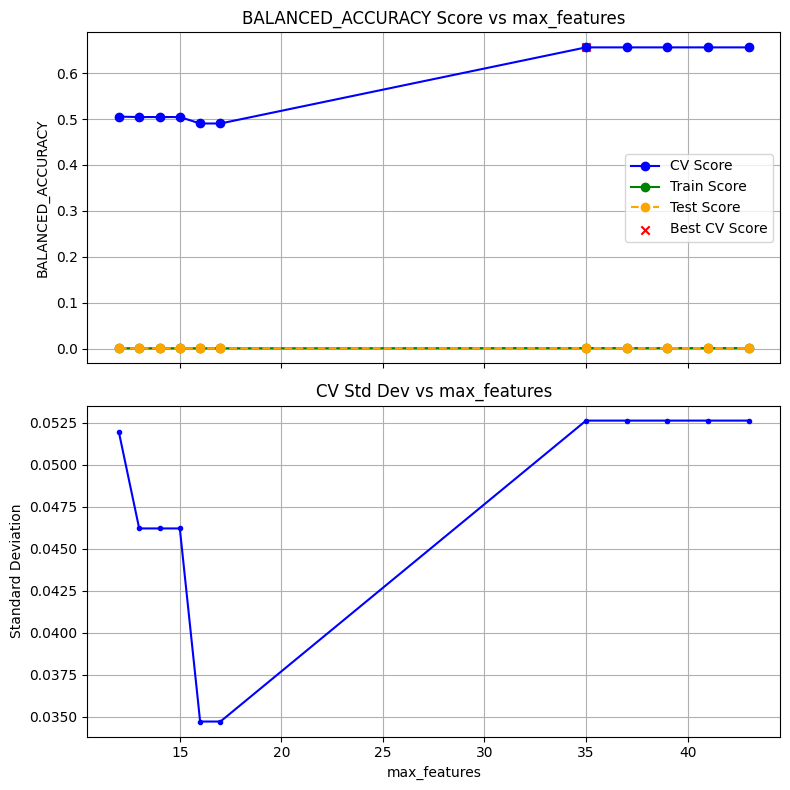

Execution Time: 00:00:06

Parameter max_features = 35    Best CV Score = 0.6562

{'n_estimators': 1, 'max_features': 35, 'max_depth': 1, 'bootstrap': False, 'min_samples_split': 2, 'min_samples_leaf': 1, 'oob_score': False, 'criterion': 'gini', 'class_weight': 'balanced', 'random_state': 42, 'Score_found': np.float64(0.6562304219977774)}



Sweeping bootstrap (balanced_accuracy): 100%|██████████| 2/2 [00:01<00:00,  1.60it/s]


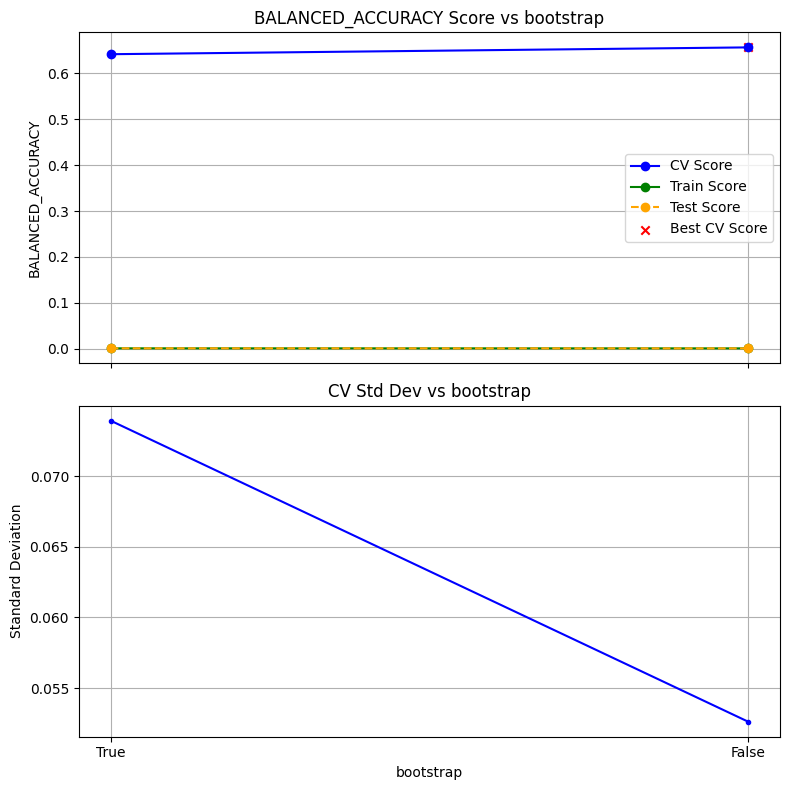

Execution Time: 00:00:01

Parameter bootstrap = False    Best CV Score = 0.6562

{'n_estimators': 1, 'max_features': 35, 'max_depth': 1, 'bootstrap': False, 'min_samples_split': 2, 'min_samples_leaf': 1, 'oob_score': False, 'criterion': 'gini', 'class_weight': 'balanced', 'random_state': 42, 'Score_found': np.float64(0.6562304219977774)}

   n_estimators max_features  max_depth  bootstrap  min_samples_split  \
0           100         sqrt        NaN       True                  2   
1           100         sqrt        1.0       True                  2   
2           100           36        1.0       True                  2   
3           100           36        1.0      False                  2   
4             1           36        1.0      False                  2   
5             1           36        1.0      False                  2   
6             1           35        1.0      False                  2   
7             1           35        1.0      False                  2   

 

In [66]:
from sklearn.ensemble import RandomForestClassifier

# Parameter grid
parameters_and_ranges = [
    ('n_estimators', range(1, 101, 10)),
    ('max_depth', range(1, 10, 1)),
    ('max_features', list(chain(range(12, 18, 1), range(35,45, 2)))),
    ('bootstrap', [True, False])
]

for param, param_values in parameters_and_ranges:
    Parameters_RF = sweep_parameter_classifier(
        model=RandomForestClassifier,
        Parameters=Parameters_RF,
        param=param,
        parameter_list=param_values,
        X_train=X_train_ready,
        y_train=y_train,
        X_test=X_test_ready,
        y_test=y_test,
        scoring='balanced_accuracy',
        n_jobs=-1,
        n_repeats=2
    )

    print(f"\nParameter {param} = {Parameters_RF[param]}    Best CV Score = {Parameters_RF['Score_found']:.4f}\n")
    print(Parameters_RF)
    print()

    Parameters_RF_List.append(Parameters_RF.copy())

RF_Results = pd.DataFrame(Parameters_RF_List)
print(RF_Results)

#### **Train a Model with Updated Hyper Parameters**

In [67]:
# Best HyperParameters

Tuned_Classifier = RandomForestClassifier(
    n_estimators=100,       
    max_features=35,    
    max_depth=1,         
    bootstrap=True,         

    min_samples_split=2,    
    min_samples_leaf=1,     
    oob_score=False,        
    criterion='gini',
    class_weight='balanced',       
    random_state=42         
)


In [77]:
run_classifier_model(
          model=Tuned_Classifier,
          X_train=X_train_ready,
          y_train=y_train, 
          scoring='balanced_accuracy',

          n_repeats=5,
          n_jobs=-1, 
          concat_results=True,
          run_comment="Tuned Hyperparameters", 
          plot_pred=True
          )

,model,model_params,mean_CV_balanced_accuracy,std_CV_balanced_accuracy,test_balanced_accuracy,run_comment
0,RandomForestClassifier,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",0.641374,0.055855,None,Tuned Hyperparameters


#### **Best Results**

In [78]:
combined_results

,model,model_params,mean_CV_f1,std_CV_f1,test_f1,run_comment,mean_CV_balanced_accuracy,std_CV_balanced_accuracy,test_balanced_accuracy
0,RandomForestClassifier,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",0.036484,0.064954,None,Baseline F1 Scoring,NaN,NaN,NaN
1,RandomForestClassifier,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",NaN,NaN,None,Baseline 'balanced Accuracy' Scoring,0.509872,0.017577,NaN
2,RandomForestClassifier,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",NaN,NaN,NaN,Tuned Hyperparameters,0.641374,0.055855,None


____

#### **GridSearch CV**

In [ ]:
print("Running GridSearchCV...")

start = time.time()

RFC = RandomForestClassifier(class_weight='balanced', random_state=42)   # Adding class_weight = 'bala

param_dist = {
    'n_estimators': range(99, 101),
    'max_depth': range(1, 6),
    'max_features': range(35, 37)
}

rcv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=42)

search = GridSearchCV(
    estimator=RFC,
    param_grid=param_dist,
    scoring='balanced_accuracy',
    cv=rcv,
    n_jobs=-1,
    return_train_score=True
)

search.fit(X_train_ready, y_train)

results = pd.DataFrame(search.cv_results_)[[
    'param_n_estimators', 'param_max_features', 'param_max_depth',
    'mean_test_score', 'std_test_score', 'mean_train_score', 'std_train_score', 'rank_test_score'
]]

results = results.sort_values(by='rank_test_score')

renamed_results = results.rename(columns={
    'param_n_estimators': 'n_estimators',
    'param_max_features': 'max_features',
    'param_max_depth': 'max_depth',
    'mean_test_score': 'mean_cv_score',
    'std_test_score': 'std_cv_score',
    'mean_train_score': 'mean_train_score',
    'std_train_score': 'std_train_score'
}).drop(columns=['rank_test_score'])

best_params = search.best_params_
best_cv_score = search.best_score_
best_cv_std = renamed_results.loc[renamed_results['mean_cv_score'] == best_cv_score, 'std_cv_score'].values[0]

RF_summary_df = pd.DataFrame({
    "Best Parameters": [str(best_params)],
    "Best CV Balanced Accuracy": [best_cv_score],
    "Std Dev of Best CV Score": [best_cv_std]
})

end = time.time()
execution_time = time.strftime('%H:%M:%S', time.gmtime(end - start))
print(f"Execution Time: {execution_time}")

# Print summary
print("\nSearch Results (Top 5) Scaled & Standardized:\n")
print(renamed_results.head(5).to_string(index=False))
print(f"\nBest Parameters: {best_params}")
print(f"Best Balanced Accuracy: {best_cv_score:.4f}")

Running GridSearchCV...
Execution Time: 00:25:45

Search Results (Top 5) Scaled & Standardized:

 n_estimators  max_features  max_depth  mean_cv_score  std_cv_score  mean_train_score  std_train_score
          100            36          1       0.642826      0.056153          0.673386         0.014183
          100            35          1       0.641374      0.055855          0.674078         0.015523
           99            35          1       0.639713      0.055455          0.673654         0.015793
           99            36          1       0.639645      0.052889          0.673801         0.014352
           99            36          2       0.634081      0.050211          0.727853         0.013850

Best Parameters: {'max_depth': 1, 'max_features': 36, 'n_estimators': 100}
Best Balanced Accuracy: 0.6428


#### **Hyperparameter Tuning Discussion**

Despite multiple rounds of hyperparameter tuning, we observed minimal improvement in the balanced_accuracy metric, and F1 scoring didn’t perform much better. This is likely due to the extremely imbalanced nature of the dataset — only 72 injury-related plays occurred out of approximately 260,000 total plays.

At this point, we could consider techniques such as sampling (e.g., oversampling the minority class, undersampling the majority class) or employ bootstrapping methods to potentially improve performance. Alternatively, we might pivot and explore models or metrics that focus exclusively on the injury cases. A few ideas in that direction include:
	•	Injury Severity Prediction
(e.g., predicting whether an injury will result in 1+ days, 7+ days, etc. out)
	•	Injury Type Classification
(e.g., classifying the injured body part: ankle, knee, etc.)

While narrowing the dataset to injury-only cases would reduce its size, it could significantly increase the relevance and signal of the data for those specific prediction tasks.

____

# 4. Storytelling With Data plot

Reproduce any graph of your choice in chapter seven (p. 165-185) of the Storytelling With Data book as best you can. You do not have to get the exact data values right, just the overall look and feel.

**Note: There is no graph in chapter 7 (pages 165 - 185), so I reproduced the graph from page 203 -- The closest graph was on 188 but that was an example of what not to do so I went with the 'corrected' version of that.**

In [80]:
fnfallplays = pd.read_csv("/Users/leemcfarling/Desktop/FNF_All_Plays.csv")

In [81]:
# ==========================================
# Remap Injury Length to ordinal Categories
# ------------------------------------------
# if injury == 1+ days then 1, 
# if injury == 42+ days then 42, etc. 
# if NO injury then 0 
# ==========================================

injury_mapping =  {"1+": 1, "7+" : 7, "28+": 28, "42+": 42}
fnfallplays['InjuryLength'] = fnfallplays['InjuryLength'].map(injury_mapping).fillna(0).astype(int)

In [82]:
# Numeric Columns
numeric_cols = fnfallplays.select_dtypes(include='number').columns
filtered_cols = [col for col in numeric_cols if 'id' not in col.lower()] # Filter OUT 'id' columns
df_numeric = fnfallplays[filtered_cols]

# Injury Plays Numeric
injury_plays_numeric = df_numeric[df_numeric['Inj_Occured'] == 1]


# Categorical 'all plays'
df_categorical_cols = fnfallplays.select_dtypes(exclude=['number']).columns
df_categorical = fnfallplays[df_categorical_cols]

# Categorical 'injury plays'
pre_categorical_injury_filtering = fnfallplays[fnfallplays['Inj_Occured'] == 1]
injury_plays_categorical_cols = pre_categorical_injury_filtering.select_dtypes(exclude=['number']).columns
injury_plays_categorical = pd.concat(
    [pre_categorical_injury_filtering[injury_plays_categorical_cols], 
     pre_categorical_injury_filtering[['InjuryLength']]], 
    axis=1
)


In [83]:
PlayType_Injury = pd.crosstab(injury_plays_categorical['PositionGroup'], injury_plays_categorical['InjuryLength'])
play_type_transposed = PlayType_Injury.T


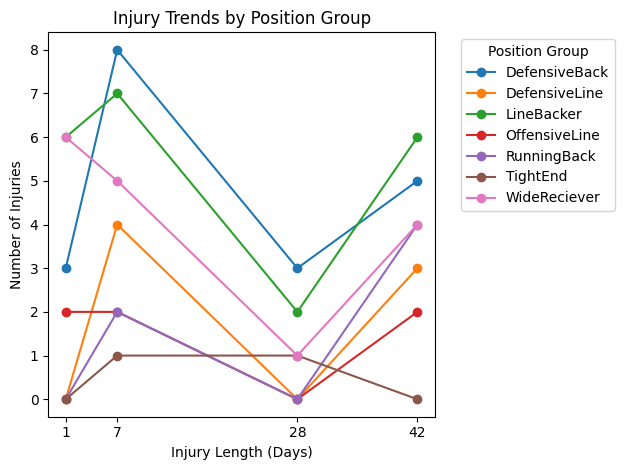

In [88]:
for col in play_type_transposed.columns:
    plt.plot(play_type_transposed.index, play_type_transposed[col], marker='o', label=col)

plt.title("Injury Trends by Position Group")
plt.xlabel("Injury Length (Days)")
plt.ylabel("Number of Injuries")
plt.xticks([1, 7, 28, 42]) 
plt.legend(title="Position Group", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

____